# 0. Install and Import Dependencies

In [1]:
! pip list

Package                      Version
---------------------------- ----------------
absl-py                      2.1.0
apturl                       0.5.2
asttokens                    2.4.1
astunparse                   1.6.3
bcrypt                       3.2.0
beautifulsoup4               4.12.3
blinker                      1.8.2
Brlapi                       0.8.3
certifi                      2020.6.20
chardet                      4.0.0
click                        8.1.7
colorama                     0.4.4
comm                         0.2.2
command-not-found            0.3
contourpy                    1.3.0
cryptography                 3.4.8
cupshelpers                  1.0
customtkinter                5.2.2
cycler                       0.12.1
darkdetect                   0.8.0
dbus-python                  1.2.18
debugpy                      1.8.5
decorator                    5.1.1
defer                        1.0.6
distro                       1.7.0
distro-info                  1.1+ubuntu

In [2]:
! pip install opencv-python matplotlib imageio gdown 

Defaulting to user installation because normal site-packages is not writeable


In [3]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import imageio

2024-11-03 14:41:32.638422: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-03 14:41:32.691417: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-03 14:41:32.708100: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-03 14:41:32.797632: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-03 14:41:33.606011: W ten

In [4]:
! nvidia-smi


Sun Nov  3 14:41:37 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.90.12              Driver Version: 550.90.12      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3050 ...    Off |   00000000:01:00.0 Off |                  N/A |
| N/A   53C    P0             15W /   80W |      15MiB /   4096MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [6]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [7]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Memory growth must be set before GPUs have been initialized
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        
        # Then we limit the memory
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=3500)])
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

# Now you can run your TensorFlow operations

1 Physical GPUs, 1 Logical GPUs


I0000 00:00:1730625103.545056    3886 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730625103.546331    3886 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730625103.547760    3886 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730625103.658593    3886 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

# 1. Build Data Loading Functions

In [8]:
import gdown

In [26]:
'''url = 'https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL'
output = 'data.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('data.zip')'''

"url = 'https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL'\noutput = 'data.zip'\ngdown.download(url, output, quiet=False)\ngdown.extractall('data.zip')"

 95%|█████████▌| 403M/423M [00:40<00:01, 10.5MB/s]

In [8]:
import cv2
import tensorflow as tf
from typing import List

def load_video(path:str) -> List[float]:

    cap = cv2.VideoCapture(path)
    frames = []
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
        ret, frame = cap.read()
        frame = tf.image.rgb_to_grayscale(frame)
        frames.append(frame[190:236,80:220,:])
    cap.release()

    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
    return tf.cast((frames - mean), tf.float32) / std

In [9]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

In [10]:
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '] (size =40)


In [11]:
char_to_num.get_vocabulary()

['',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 "'",
 '?',
 '!',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ' ']

In [12]:
char_to_num(['n','i','g','g'])

<tf.Tensor: shape=(4,), dtype=int64, numpy=array([14,  9,  7,  7])>

In [13]:
num_to_char([14,  9,  3, 11])

<tf.Tensor: shape=(4,), dtype=string, numpy=array([b'n', b'i', b'c', b'k'], dtype=object)>

In [14]:
def load_alignments(path:str) -> List[str]:
    with open(path, 'r') as f:
        lines = f.readlines()
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil':
            tokens = [*tokens,' ',line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

In [15]:
def load_data(path: str):
    path = bytes.decode(path.numpy())
    file_name = path.split('/')[-1].split('.')[0]
    # File name splitting for windows
    #file_name = path.split('\\')[-1].split('.')[0]
    video_path = os.path.join('data','s1',f'{file_name}.mpg')
    alignment_path = os.path.join('data','alignments','s1',f'{file_name}.align')
    frames = load_video(video_path)
    alignments = load_alignments(alignment_path)

    return frames, alignments

In [16]:
test_path = 'data/s1/bbaf4p.mpg'

In [17]:
tf.convert_to_tensor(test_path).numpy().decode('utf-8').split('/')[-1].split('.')[0]

'bbaf4p'

In [18]:
frames, alignments = load_data(tf.convert_to_tensor(test_path))

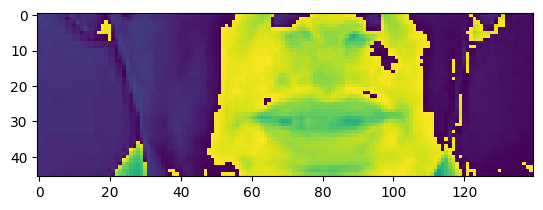

In [19]:
plt.imshow(frames[20])

In [20]:
alignments

<tf.Tensor: shape=(25,), dtype=int64, numpy=
array([ 2,  9, 14, 39,  2, 12, 21,  5, 39,  1, 20, 39,  6, 39,  6, 15, 21,
       18, 39, 16, 12,  5,  1, 19,  5])>

In [21]:
tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at f four please'>

In [22]:
def mappable_function(path:str) ->List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

# 2. Create Data Pipeline

In [23]:
from matplotlib import pyplot as plt

In [24]:
data = tf.data.Dataset.list_files('./data/s1/*.mpg')
data = data.shuffle(500, reshuffle_each_iteration=False)
data = data.map(mappable_function)
data = data.padded_batch(2, padded_shapes=([75,None,None,None],[40]))
data = data.prefetch(tf.data.AUTOTUNE)
# Added for split
train = data.take(400)
test = data.skip(400)

In [40]:
data = tf.data.Dataset.list_files('./data/s1/*.mpg')
data = data.shuffle(500, reshuffle_each_iteration=False)
data = data.map(mappable_function)
data = data.padded_batch(2, padded_shapes=([75,None,None,None],[40]))
data = data.prefetch(tf.data.AUTOTUNE)
train = data.take(400)
valid= data.skip(400).take(50)
test = data.skip(450).take(50)

In [ ]:
len(test)

50

In [ ]:
len(test)

In [43]:
frames, alignments = data.as_numpy_iterator().next()

In [44]:
len(frames)

2

In [45]:
sample = data.as_numpy_iterator()

In [46]:
val = sample.next(); val[0]

array([[[[[ 1.6406872 ],
          [ 1.6042275 ],
          [ 1.5677679 ],
          ...,
          [ 0.36459717],
          [ 0.4375166 ],
          [ 0.4375166 ]],

         [[ 1.6042275 ],
          [ 1.5677679 ],
          [ 1.4948484 ],
          ...,
          [ 0.4010569 ],
          [ 0.4375166 ],
          [ 0.4375166 ]],

         [[ 1.4948484 ],
          [ 1.4948484 ],
          [ 1.4948484 ],
          ...,
          [ 0.4010569 ],
          [ 0.4010569 ],
          [ 0.4010569 ]],

         ...,

         [[ 1.0573318 ],
          [ 1.0573318 ],
          [ 1.0573318 ],
          ...,
          [ 0.10937915],
          [ 0.10937915],
          [ 0.10937915]],

         [[ 1.0573318 ],
          [ 1.0573318 ],
          [ 1.0573318 ],
          ...,
          [ 0.10937915],
          [ 0.10937915],
          [ 0.10937915]],

         [[ 1.0573318 ],
          [ 1.0573318 ],
          [ 1.0573318 ],
          ...,
          [ 0.10937915],
          [ 0.10937915],
          

In [ ]:
#imageio.mimsave('./animation.gif', val[0][0], fps=10)

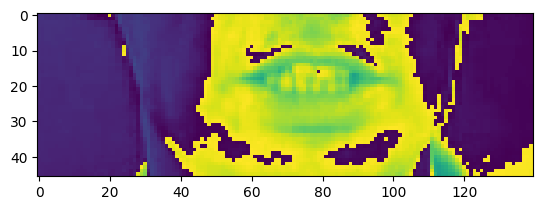

In [30]:
# 0:videos, 0: 1st video out of the batch,  0: return the first frame in the video
plt.imshow(val[0][0][35])

In [31]:
tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'place green in d six please'>

# 3. Design the Deep Neural Network

In [32]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [33]:
data.as_numpy_iterator().next()[0][0].shape

(75, 46, 140, 1)

In [120]:
from tensorflow.keras.layers import Reshape

# Model architecture
model = Sequential()
model.add(Conv3D(128, 3, input_shape=(75, 46, 140, 1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1, 2, 2)))

model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1, 2, 2)))

model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1, 2, 2)))


model.add(TimeDistributed(Reshape((-1,))))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(0.5))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(0.5))

model.add(Dense(char_to_num.vocabulary_size() + 1, kernel_initializer='he_normal', activation='softmax'))


/home/jeevan/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [121]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d_15 (Conv3D)              │ (None, 75, 46, 140,    │         3,584 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_15 (Activation)      │ (None, 75, 46, 140,    │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_15 (MaxPooling3D) │ (None, 75, 23, 70,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_16 (Conv3D)              │ (None, 75, 23, 70,     │       884,992 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_16 (Activation)      │ (None, 75, 23, 70,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_16 (MaxPooling3D) │ (None, 75, 11, 35,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_17 (Conv3D)              │ (None, 75, 11, 35, 75) │       518,475 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_17 (Activation)      │ (None, 75, 11, 35, 75) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_17 (MaxPooling3D) │ (None, 75, 5, 17, 75)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_4              │ (None, 75, 6375)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_8 (Bidirectional) │ (None, 75, 256)        │     6,660,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 75, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_9 (Bidirectional) │ (None, 75, 256)        │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 75, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 75, 41)         │        10,537 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,471,924 (32.32 MB)

 Trainable params: 8,471,924 (32.32 MB)

 Non-trainable params: 0 (0.00 B)

In [122]:
5*17*75

6375

In [47]:
yhat = model.predict(val[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


In [48]:
tf.strings.reduce_join([num_to_char(x) for x in tf.argmax(yhat[0],axis=1)])

<tf.Tensor: shape=(), dtype=string, numpy=b'place  bbluuue  wwitth  dd  zeeroooo  pplleeaasseee'>

In [49]:
tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in yhat[0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'place  bbluuue  wwitth  dd  zeeroooo  pplleeaasseee'>

In [50]:
model.input_shape

(None, 75, 46, 140, 1)

In [51]:
model.output_shape

(None, 75, 41)

# 4. Setup Training Options and Train

In [39]:
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr
    

In [34]:
@tf.keras.utils.register_keras_serializable()
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [109]:
'''
class ProduceExample(tf.keras.callbacks.Callback):
    def __init__(self, dataset) -> None:
        self.dataset = dataset.as_numpy_iterator()

    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
        print('Original:', tf.strings.reduce_join(num_to_char(data[1][0])).numpy().decode('utf-8'))
        print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[0])).numpy().decode('utf-8'))
        print('~'*100)
'''

"\nclass ProduceExample(tf.keras.callbacks.Callback):\n    def __init__(self, dataset) -> None:\n        self.dataset = dataset.as_numpy_iterator()\n\n    def on_epoch_end(self, epoch, logs=None) -> None:\n        data = self.dataset.next()\n        yhat = self.model.predict(data[0])\n        decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()\n        print('Original:', tf.strings.reduce_join(num_to_char(data[1][0])).numpy().decode('utf-8'))\n        print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[0])).numpy().decode('utf-8'))\n        print('~'*100)\n"

In [35]:
class ProduceExample(tf.keras.callbacks.Callback):
    def __init__(self, dataset) -> None:
        super().__init__()  # Ensure to call the parent constructor
        self.dataset = dataset.as_numpy_iterator()
        self.data_iterator = None  # Initialize a data iterator

    def on_epoch_begin(self, epoch, logs=None) -> None:
        # Reset the iterator at the beginning of each epoch
        self.data_iterator = self.dataset

    def on_epoch_end(self, epoch, logs=None) -> None:
        # Get the next batch of data
        try:
            data = next(self.data_iterator)
            yhat = self.model.predict(data[0])
            decoded = tf.keras.backend.ctc_decode(yhat, [75, 75], greedy=False)[0][0].numpy()

            # Decode and print original and predicted strings
            original_str = tf.strings.reduce_join(num_to_char(data[1][0])).numpy().decode('utf-8')
            predicted_str = tf.strings.reduce_join(num_to_char(decoded[0])).numpy().decode('utf-8')

            print('Original:', original_str)
            print('Prediction:', predicted_str)
            print('~' * 100)

        except StopIteration:
            print("No more data available for predictions.")


In [52]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)

In [132]:
checkpoint_callback = ModelCheckpoint(os.path.join('models','checkpoint','fifty.weights.h5'), monitor='loss', save_weights_only=True)

In [133]:
schedule_callback = LearningRateScheduler(scheduler)

In [53]:
example_callback = ProduceExample(test)

In [ ]:
model.fit(train, validation_data=valid, epochs=80, callbacks=[example_callback])

## Save model

In [55]:
model.save('80_10_10.keras')

# 5. Make a Prediction

In [36]:
from tensorflow.keras.models import load_model
model = load_model("model.keras", custom_objects={'ctc_loss': CTCLoss})

/home/jeevan/.local/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 42 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [37]:
test_data = test.as_numpy_iterator()

In [52]:
sample = test_data.next()

[mpeg1video @ 0x7a6568195940] ac-tex damaged at 22 17
[mpeg1video @ 0x7a6568195940] Warning MVs not available


In [53]:
yhat = model.predict(sample[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


In [54]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in sample[1]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'lay blue at x nine soon'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'set red by b seven again'>]

In [55]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75,75], greedy=True)[0][0].numpy()

In [56]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'lay blue at x nine soon'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'set red by b seven again'>]

# Test on a Video

In [46]:
sample = load_data(tf.convert_to_tensor('data/s1/swiu6p.mpg'))

In [47]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in [sample[1]]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'set white in u six please'>]

In [48]:
yhat = model.predict(tf.expand_dims(sample[0], axis=0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


In [49]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75], greedy=True)[0][0].numpy()

In [50]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'set white in u six please'>]

# CER and WER

In [57]:
import tensorflow as tf
import jiwer

# Lists to store ground truth and predicted sentences
ground_truth_list = []
predicted_list = []

# Iterate over the padded test dataset
for batch in test:
    # Get the batch of data and labels
    x_batch, y_batch = batch

    # Predict using the model
    y_pred = model.predict(x_batch)

    # Decode the predicted batch
    decoded_pred = tf.keras.backend.ctc_decode(y_pred, input_length=[75 for _ in range(len(y_pred))], greedy=True)[0][0].numpy()

    # Convert both ground truth and predicted values to strings
    ground_truth_strings = [tf.strings.reduce_join(num_to_char(word)).numpy().decode('utf-8') for word in y_batch]
    predicted_strings = [tf.strings.reduce_join(num_to_char(word)).numpy().decode('utf-8') for word in decoded_pred]

    # Append to lists
    ground_truth_list.extend(ground_truth_strings)
    predicted_list.extend(predicted_strings)


# Compute CER for the entire dataset
cer = jiwer.cer(ground_truth_list, predicted_list)
print(f"Character Error Rate for test dataset: {cer}")

# Compute WER for the entire dataset
wer = jiwer.wer(ground_truth_list, predicted_list)
print(f"Word Error Rate for test dataset: {wer}")


[mpeg1video @ 0x7a697401c100] ac-tex damaged at 22 17
[mpeg1video @ 0x7a697401c100] Warning MVs not available


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s

2024-11-03 15:13:11.538454: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


# Loss Graphs

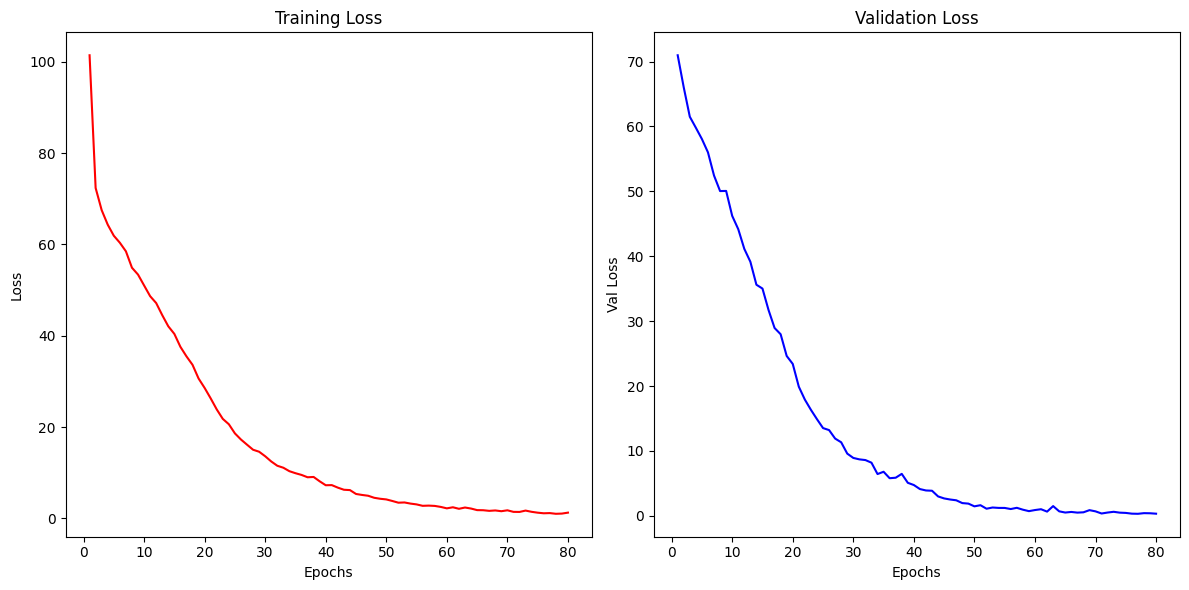

In [1]:
import matplotlib.pyplot as plt

loss_values = [
    101.4487, 72.3761, 67.5191, 64.3383, 61.9207, 60.3831, 58.5048, 54.9079, 53.4087, 51.0339, 48.6791, 47.1699,
    44.5235, 42.0773, 40.4132, 37.5807, 35.4942, 33.6463, 30.6426, 28.5764, 26.2876, 23.8713, 21.7952, 20.6236,
    18.6210, 17.2756, 16.1465, 15.0383, 14.6011, 13.6129, 12.4684, 11.5329, 11.0969, 10.3373, 9.8979, 9.5228,
    9.0090, 9.0752, 8.1214, 7.2617, 7.2900, 6.7348, 6.2746, 6.1971, 5.3507, 5.1351, 4.9604, 4.5152, 4.2976,
    4.1555, 3.8123, 3.4384, 3.4903, 3.2411, 3.0647, 2.7539, 2.8000, 2.7340, 2.5137, 2.1992, 2.4356, 2.1018,
    2.3807, 2.1558, 1.8112, 1.7893, 1.6514, 1.7389, 1.5735, 1.7709, 1.4300, 1.4131, 1.7116, 1.4398, 1.2502,
    1.1190, 1.1619, 1.0068, 1.0529, 1.2590
]

val_loss_values = [
    70.9637, 66.0087, 61.4914, 59.7941, 58.0526, 55.9951, 52.4257, 50.0377, 50.0571, 46.2146, 44.1661, 41.1321,
    39.1487, 35.6049, 35.0143, 31.7128, 28.9381, 27.9748, 24.6268, 23.4013, 19.8957, 17.9036, 16.3288, 14.8880,
    13.5173, 13.2070, 11.9014, 11.3259, 9.5831, 8.9175, 8.6965, 8.5880, 8.1840, 6.4338, 6.7868, 5.7928, 5.8686,
    6.4612, 5.0857, 4.7411, 4.1208, 3.9035, 3.8614, 2.9867, 2.6768, 2.5098, 2.3897, 1.9596, 1.8797, 1.4579,
    1.6333, 1.0925, 1.2778, 1.2153, 1.2122, 1.0427, 1.2327, 0.9436, 0.7178, 0.8871, 1.0146, 0.6450, 1.4959,
    0.6885, 0.5028, 0.5939, 0.4915, 0.5384, 0.8710, 0.6837, 0.3548, 0.5042, 0.6169, 0.4860, 0.4450, 0.3309,
    0.3095, 0.4080, 0.3917, 0.3258
]

epochs = list(range(1, len(loss_values) + 1))

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, loss_values, color='red')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs, val_loss_values, color='blue')
plt.title('Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Val Loss')

plt.tight_layout()
plt.show()

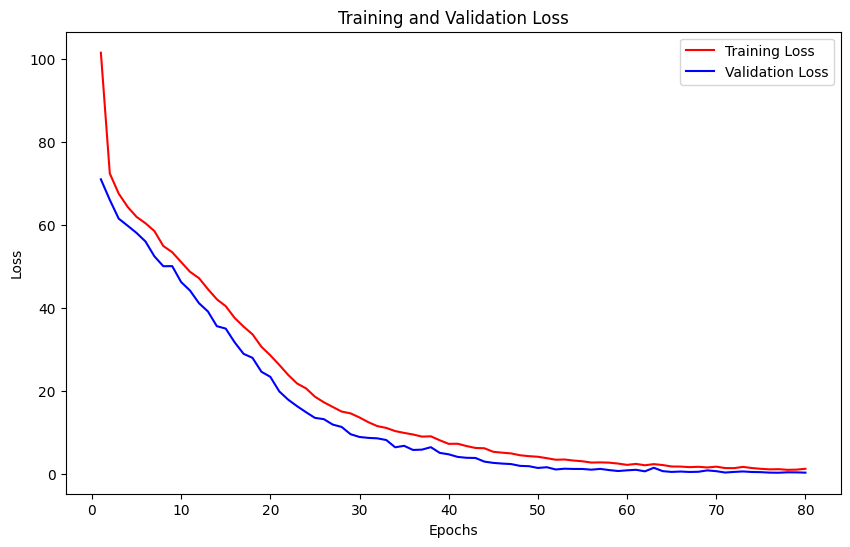

In [2]:
epochs = list(range(1, len(loss_values) + 1))

plt.figure(figsize=(10, 6))

plt.plot(epochs, loss_values, color='red', label='Training Loss')
plt.plot(epochs, val_loss_values, color='blue', label='Validation Loss')

plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()